
Convolutional Neural Networks
===============

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.


ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Layers used to build ConvNets:

- INPUT [28x28x1] will hold the raw pixel values of the image, in this case an image of width 28, height 28, and with one color channel.
- CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [28x28x12] if we decided to use 12 filters.
- RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([28x28x12]).
- POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x14x12].
- FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10]

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

### Load the data

We are using MINIST Dataset

In [36]:
# Define a transform the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Define the network
------------------

Let’s define this network:



In [50]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

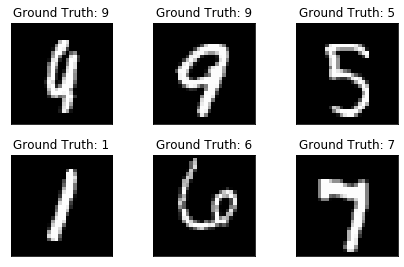

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [40]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [41]:
# Loss Function
criterion = nn.NLLLoss()

### Training the Network

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with loss.backward() to calculate the gradients
* Take a step with the optimizer to update the weights


In [28]:
# Loss Function
criterion = nn.NLLLoss()

In [42]:
epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in trainloader:
        # Clear the gradeints
        optimizer.zero_grad()
        # Forward pass, get our logits
        log_ps = net(images)
        # Calculate the loss with the logits and the labels
        loss = criterion(log_ps, labels)
        # Calculate the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = net(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

/home/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/15..  Training Loss: 1.303..  Test Loss: 0.310..  Test Accuracy: 0.915
Epoch: 2/15..  Training Loss: 0.526..  Test Loss: 0.189..  Test Accuracy: 0.946
Epoch: 3/15..  Training Loss: 0.406..  Test Loss: 0.154..  Test Accuracy: 0.954
Epoch: 4/15..  Training Loss: 0.350..  Test Loss: 0.121..  Test Accuracy: 0.965
Epoch: 5/15..  Training Loss: 0.307..  Test Loss: 0.108..  Test Accuracy: 0.969
Epoch: 6/15..  Training Loss: 0.281..  Test Loss: 0.092..  Test Accuracy: 0.972
Epoch: 7/15..  Training Loss: 0.265..  Test Loss: 0.089..  Test Accuracy: 0.974
Epoch: 8/15..  Training Loss: 0.246..  Test Loss: 0.077..  Test Accuracy: 0.976


KeyboardInterrupt: 

In [53]:
with torch.no_grad():
    output = net(example_data)

/home/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


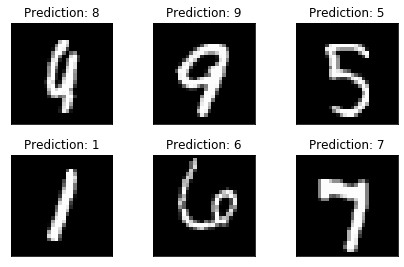

In [54]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])